In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-08-12 13:20:39.006023: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 13:20:39.057211: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 13:20:39.058010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 13:20:40.219457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0eepip4Streams.root"
file_signal_ele="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0eepip200000.root"


In [3]:
mc_ele_signal,mc_ele_only_signal,mc_ele_scf,mc_ele_bkg, mc_ele_signal_weight,mc_ele_only_signal_weight,mc_ele_scf_weight,mc_ele_bkg_weight = process_MC_data_combined(file_signal_ele, file_bkg_ele, 'ele', '511', 'pip', 'ee', 0, 'rec511','PIDCorrectionAndAcceptanceWeight')


In [4]:
fit_and_integrate(mc_ele_signal, param_fl_start=0.5, param_s3_start=0.01, param_p5_start=0.02, floating=True)


/tmp/ipykernel_1052230/4262147721.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cosTheta_L'] = data['cosTheta_L'].abs()
/tmp/ipykernel_1052230/4262147721.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phi_b_gr['phi_B'] = 2 * np.pi - phi_b_gr['phi_B']


name                  value  (rounded)        hesse    at limit
------------------  ------------------  -----------  ----------
extended_0.9516236             66597.6  +/-   3e-05       False
param_fl_0.9516236            0.517411  +/-  0.0087       False
param_s3_0.9516236          -0.0512032  +/-  0.0084       False
param_p5_0.9516236           -0.431331  +/-   0.019       False
Fit result valid:
True
Signal Events in MC Data = 66597.59261205263
Integrated PDF with trim: 1.0003828387115032
Integrated PDF without trim: 1.0798699271822993
Proportion of data lost: 0.0736


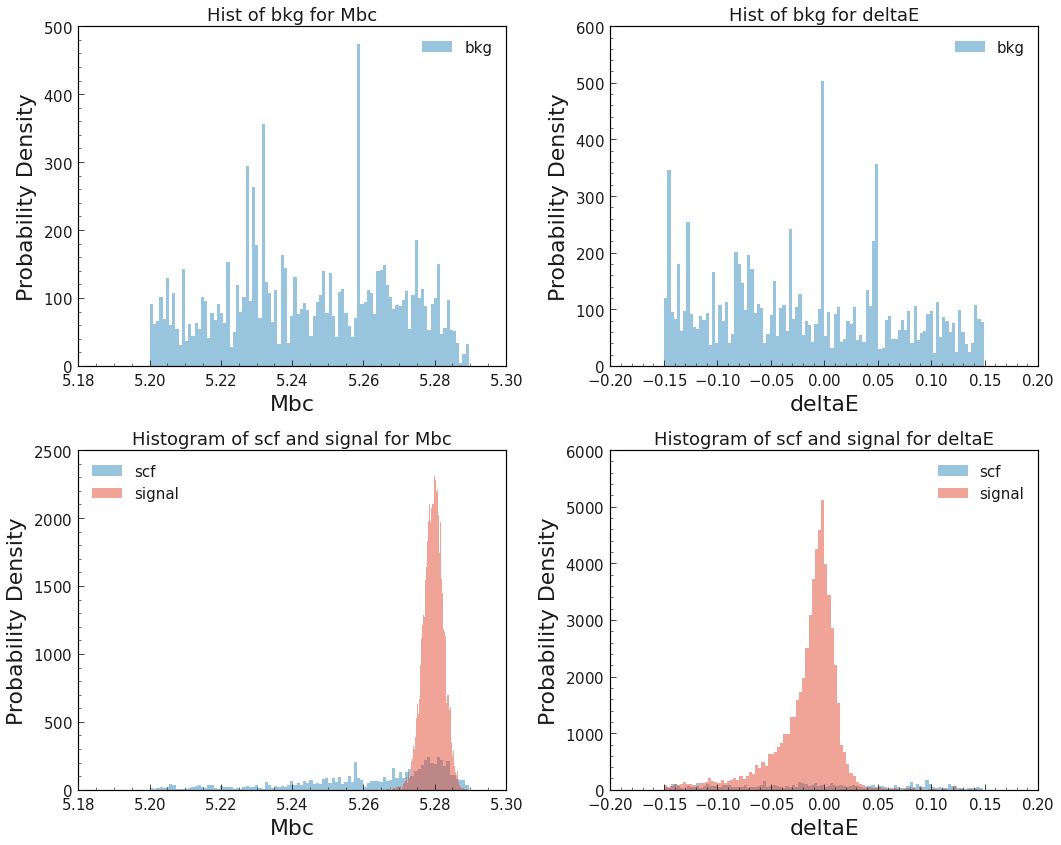

In [5]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0], {"bkg":  mc_ele_bkg["Mbc"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1], {"bkg": mc_ele_bkg["deltaE"]},
               ["bkg"],
               {"bkg": mc_ele_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0], {"scf": mc_ele_scf["Mbc"], 
                           "signal": mc_ele_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1], {"scf": mc_ele_scf["deltaE"], 
                           "signal": mc_ele_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_ele_scf_weight, "signal": mc_ele_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Fit ##

In [45]:
def fit(label,particle_type, dataset_name, mc_label_particle_type_dataset_name_data, mc_label_particle_type_dataset_name_weight, model_type,q2_reg):
    
    if label == 'Mbc':
        obs_label = zfit.Space(label, limits=(5.20, 5.29))
        
    elif label == 'deltaE':
        obs_label = zfit.Space(label, limits=(-0.15, 0.15))
        
    else:
        raise ValueError(f"Unknown label: {label}")
        
    if particle_type == 'ele':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight
    elif particle_type == 'mu':
        mc_dataset_name_data_label = mc_label_particle_type_dataset_name_data
        mc_dataset_name_weight_label = mc_label_particle_type_dataset_name_weight

    r = round(np.random.rand(), 4)
    ratios_label_dataset_model_type = None
        

    if model_type == 'cb':
        
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", 5.279)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.005)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 4)
        
        
        label_dataset_name_model_type = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)
        
    
    elif model_type == 'cb_gauss':
        # CrystalBall
        mu_particle_type_label_dataset_name_cb = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_cb_{r}", -0.0)
        sigma_particle_type_label_dataset_name_cb = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_cb_{r}", 0.09)
        alpha_particle_type_label_dataset_name_cb = zfit.Parameter(f"alpha_{particle_type}_{label}_{dataset_name}_cb_{r}", 1)
        n_particle_type_label_dataset_name_cb = zfit.Parameter(f"n_{particle_type}_{label}_{dataset_name}_cb_{r}", 2)

        label_dataset_name_cb = zfit.pdf.CrystalBall(
                obs=obs_label, mu=mu_particle_type_label_dataset_name_cb, sigma=sigma_particle_type_label_dataset_name_cb,
                alpha=alpha_particle_type_label_dataset_name_cb, n=n_particle_type_label_dataset_name_cb)

        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", -0.0)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.096)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)

        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}",0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_cb, label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus_gauss':

        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.29, 5.28, 5.3)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-60)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Gaussian
        mu_particle_type_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", 5.278)
        sigma_particle_type_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.005)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_particle_type_label_dataset_name_gauss, sigma=sigma_particle_type_label_dataset_name_gauss)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_argus,label_dataset_name_gauss],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'poly_argus':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_argus = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        # Fraction
        frac_particle_type_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly, label_dataset_name_argus],
            fracs=[frac_particle_type_label_dataset_name_model_type],
            obs=obs_label)
        
        
    elif model_type == 'poly_gauss':
        
        # Polynomial
        coeff0_mu_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_mu_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_poly = zfit.pdf.Chebyshev(
                obs=obs_label,coeffs=[coeff0_mu_label_dataset_name_poly, coeff1_mu_label_dataset_name_poly])

        # Gaussian
        mu_mu_label_dataset_name_gauss = zfit.Parameter(f"mu_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.0)
        sigma_mu_label_dataset_name_gauss = zfit.Parameter(f"sigma_{particle_type}_{label}_{dataset_name}_gauss_{r}", 0.008)

        label_dataset_name_gauss = zfit.pdf.Gauss(
            obs=obs_label, mu=mu_mu_label_dataset_name_gauss, sigma=sigma_mu_label_dataset_name_gauss)
        
        # Fraction
        frac_mu_label_dataset_name_model_type = zfit.Parameter(f"frac_{particle_type}_{label}_{dataset_name}_{model_type}_{r}", 0.5)

        label_dataset_name_model_type = zfit.pdf.SumPDF(
            pdfs=[label_dataset_name_poly,label_dataset_name_gauss],
            fracs=[frac_mu_label_dataset_name_model_type],
            obs=obs_label)
        
    elif model_type == 'argus':
        
        # Argus
        m_particle_type_label_dataset_name_argus = zfit.Parameter(f"m_{particle_type}_{label}_{dataset_name}_argus_{r}", 5.289)
        c_particle_type_label_dataset_name_argus = zfit.Parameter(f"c_{particle_type}_{label}_{dataset_name}_argus_{r}",-120)
        p_particle_type_label_dataset_name_argus= zfit.Parameter(f"p_{particle_type}_{label}_{dataset_name}_argus_{r}", 0.5)

        label_dataset_name_model_type = zphysics.pdf.Argus(
            obs=obs_label, m0=m_particle_type_label_dataset_name_argus, c=c_particle_type_label_dataset_name_argus, p=p_particle_type_label_dataset_name_argus)
        
        
    elif model_type == 'poly':
        
        # Polynomial
        coeff0_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff0_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)
        coeff1_particle_type_label_dataset_name_poly = zfit.Parameter(f'coeff1_{particle_type}_{label}_{dataset_name}_poly_{r}', 0.0)

        label_dataset_name_model_type = zfit.pdf.Chebyshev(obs=obs_label, coeffs=[coeff0_particle_type_label_dataset_name_poly, coeff1_particle_type_label_dataset_name_poly])

    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
        
    
    data_label_dataset_name = zfit.data.Data.from_pandas(
    mc_dataset_name_data_label,
    obs=obs_label,
    weights=mc_dataset_name_weight_label
    )
   
    nll_label_dataset_name = zfit.loss.UnbinnedNLL(model=label_dataset_name_model_type, data=data_label_dataset_name)
    minimizer_label_dataset_name = zfit.minimize.Minuit()
    result_label_dataset_name = minimizer_label_dataset_name.minimize(nll_label_dataset_name)
    
    # Extract and save the parameter values
    parameters_values = {
        "_".join(param.name.split('_')[:-1]): param.numpy() for param in label_dataset_name_model_type.get_params()
    }
    ratios_label_dataset_model_type = pd.DataFrame(parameters_values, index=[0])
    ratios_label_dataset_model_type.to_csv(f"parameter_{particle_type}_{label}_{dataset_name}_{model_type}_{q2_reg}.csv", index=False)
    
    return label_dataset_name_model_type,result_label_dataset_name


In [46]:
# signal
Mbc_only_signal_cb, result_Mbc_signal = fit('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss, result_deltaE_signal = fit('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)

#scf
Mbc_scf_argus_gauss, result_Mbc_scf = fit('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss, result_deltaE_scf = fit('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)

#bkg
Mbc_bkg_argus_gauss, result_Mbc_bkg = fit('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss, result_deltaE_bkg = fit('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)



name                              value  (rounded)    at limit
------------------------------  ------------------  ----------
mu_ele_Mbc_signal_cb_0.7426                5.27967       False
sigma_ele_Mbc_signal_cb_0.7426          0.00266067       False
alpha_ele_Mbc_signal_cb_0.7426             1.84091       False
n_ele_Mbc_signal_cb_0.7426                 17.6392       False
True
name                                      value  (rounded)    at limit
--------------------------------------  ------------------  ----------
frac_ele_deltaE_signal_cb_gauss_0.0492            0.912883       False
mu_ele_deltaE_signal_cb_0.0492                 -0.00322704       False
sigma_ele_deltaE_signal_cb_0.0492                0.0112351       False
alpha_ele_deltaE_signal_cb_0.0492                 0.749865       False
n_ele_deltaE_signal_cb_0.0492                      4.23901       False
mu_ele_deltaE_signal_gauss_0.0492               -0.0486704       False
sigma_ele_deltaE_signal_gauss_0.0492             

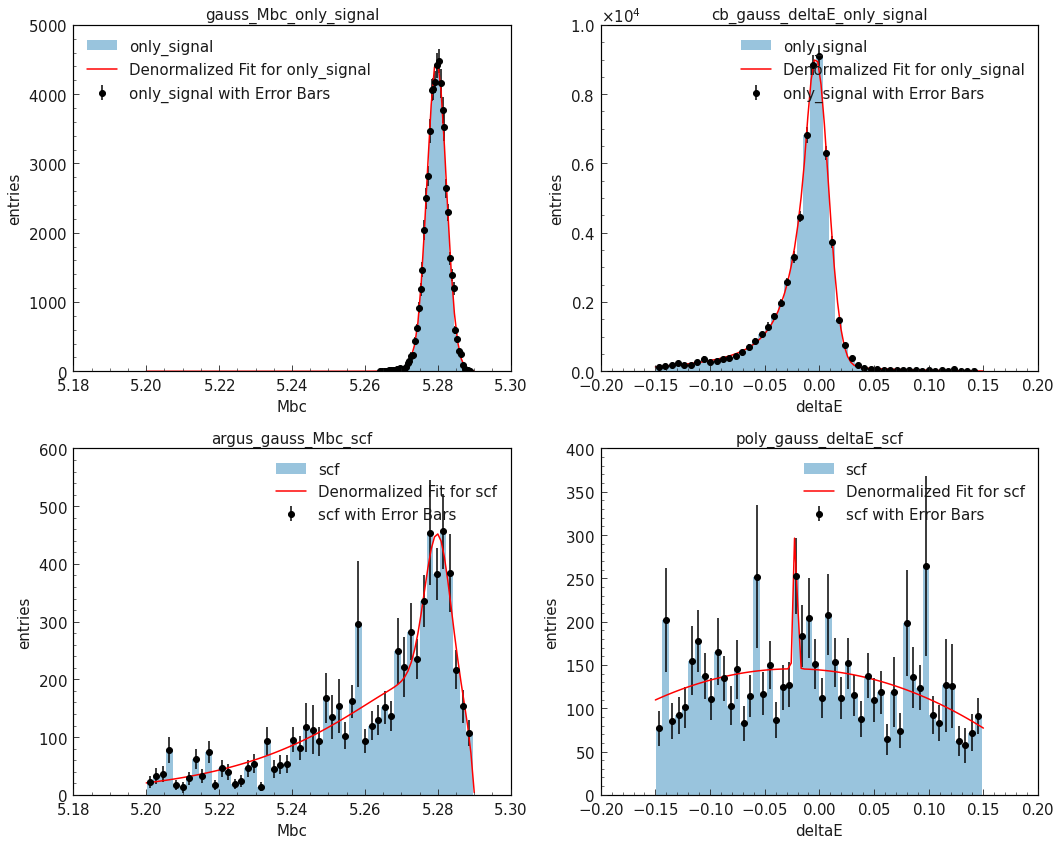

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Changed to 1 row, 2 columns

Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)

fit_model_Mbc_only_signal = plot_with_fit(axs[0,0],50, mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight, 
                                           Mbc_only_signal_cb, Mbc_range, 
                                           'only_signal', 'Denormalized Fit for only_signal', 
                                           'Mbc', 'entries', 'gauss_Mbc_only_signal')


fit_model_deltaE_only_signal = plot_with_fit(axs[0,1],50, mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight, 
                                             deltaE_only_signal_cb_gauss, deltaE_range, 
                                             'only_signal', 'Denormalized Fit for only_signal', 
                                             'deltaE', 'entries', 'cb_gauss_deltaE_only_signal')

fit_model_Mbc_scf = plot_with_fit(axs[1,0],50, mc_ele_scf["Mbc"], mc_ele_scf_weight, 
                                            Mbc_scf_argus_gauss, Mbc_range, 
                                           'scf', 'Denormalized Fit for scf', 
                                           'Mbc', 'entries', 'argus_gauss_Mbc_scf')


fit_model_deltaE_scf = plot_with_fit(axs[1,1],50, mc_ele_scf["deltaE"], mc_ele_scf_weight, 
                                             deltaE_scf_poly_gauss, deltaE_range, 
                                             'scf', 'Denormalized Fit for scf', 
                                             'deltaE', 'entries', 'poly_gauss_deltaE_scf')




# Adjust layout
plt.tight_layout()


# Print results if needed
print(result_Mbc_signal.params)
print(result_Mbc_signal.valid)
print(result_deltaE_signal.params)
print(result_deltaE_signal.valid)
print(result_Mbc_scf.params)
print(result_Mbc_scf.valid)
print(result_deltaE_scf.params)
print(result_deltaE_scf.valid)

# Show the plots
plt.show()

name                                   value  (rounded)    at limit
-----------------------------------  ------------------  ----------
frac_ele_Mbc_bkg_argus_gauss_0.6535             0.89434       False
m_ele_Mbc_bkg_argus_0.6535                      5.28921       False
c_ele_Mbc_bkg_argus_0.6535                     -69.7078       False
p_ele_Mbc_bkg_argus_0.6535                      1.12477       False
mu_ele_Mbc_bkg_gauss_0.6535                     5.27624       False
sigma_ele_Mbc_bkg_gauss_0.6535               0.00988299       False
True
name                                 value  (rounded)    at limit
---------------------------------  ------------------  ----------
coeff0_ele_deltaE_bkg_poly_0.4513           -0.340554       False
coeff1_ele_deltaE_bkg_poly_0.4513          -0.0458574       False
True


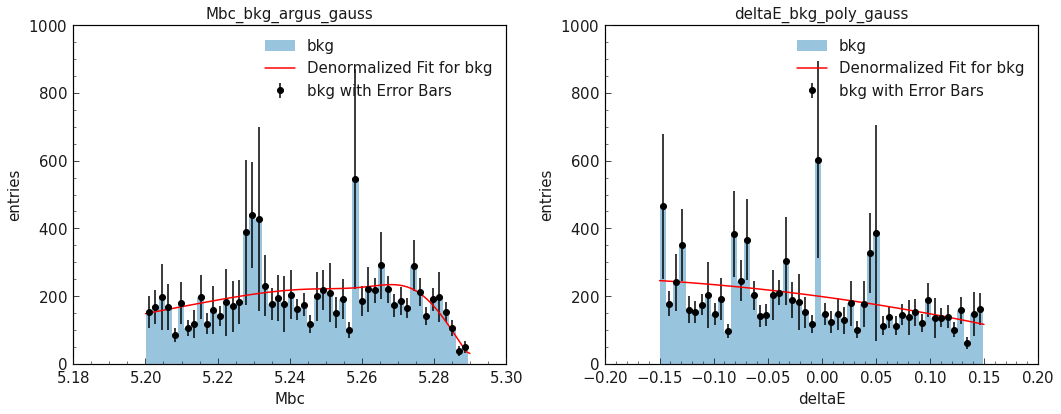

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))  # Changed to 1 row, 2 columns


Mbc_range = np.linspace(5.20, 5.29, 100)
deltaE_range = np.linspace(-0.15, 0.15, 100)


fit_model_Mbc_bkg = plot_with_fit(axs[0],50, mc_ele_bkg["Mbc"], mc_ele_bkg_weight, 
                                         Mbc_bkg_argus_gauss, Mbc_range, 
                                         'bkg', 'Denormalized Fit for bkg', 
                                         'Mbc', 'entries', 'Mbc_bkg_argus_gauss')


fit_model_deltaE_bkg = plot_with_fit(axs[1],50, mc_ele_bkg["deltaE"], mc_ele_bkg_weight,
                                             deltaE_bkg_poly_gauss, deltaE_range, 
                                             'bkg', 'Denormalized Fit for bkg', 
                                             'deltaE', 'entries', 'deltaE_bkg_poly_gauss')



# Adjust layout
plt.tight_layout()

# Print results if needed
print(result_Mbc_bkg.params)
print(result_Mbc_bkg.valid)
print(result_deltaE_bkg.params)
print(result_deltaE_bkg.valid)


# Show the plots
plt.show()

## Yield

In [9]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed_unfixed_data('Mbc','ele', 'signal', mc_ele_only_signal["Mbc"], mc_ele_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'signal',mc_ele_only_signal["deltaE"], mc_ele_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','ele', 'scf', mc_ele_scf["Mbc"], mc_ele_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'scf', mc_ele_scf["deltaE"], mc_ele_scf_weight,'poly_gauss',0)


#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed_unfixed_data('Mbc','ele', 'bkg',  mc_ele_bkg["Mbc"], mc_ele_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed_unfixed_data('deltaE','ele', 'bkg',  mc_ele_bkg["deltaE"], mc_ele_bkg_weight,'poly',0)



In [10]:
Signal_Mbc = mc_ele_only_signal["Mbc"]
Signal_deltaE = mc_ele_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_ele_scf["Mbc"],mc_ele_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_ele_scf["deltaE"],mc_ele_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_ele_only_signal_weight
Background_weight = pd.concat([mc_ele_scf_weight,mc_ele_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    Mbc_only_signal_cb_fixed,Mbc_scf_argus_gauss_fixed,deltaE_only_signal_cb_gauss_fixed,deltaE_scf_poly_gauss_fixed,
    Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),1,1,10000,10000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                                      value  (rounded)               errors    at limit
--------------------------------------  ------------------  -------------------  ----------
signal_yield_0.8212                                58452.5  -3.5e+02   +3.5e+02       False
background_yield_0.8212                            17804.2  -2.8e+02   +2.9e+02       False
mu_ele_Mbc_signal_cb_0.0761                         5.2797  -1.2e-05   +1.2e-05       False
frac_ele_deltaE_signal_cb_gauss_0.0396            0.956566  - 0.0055   + 0.0056       False
frac_Mbc_bkg1_0.8212                              0.394082  -  0.033   +  0.032       False
frac_ele_Mbc_scf_argus_gauss_0.8655               0.732996  -  0.038   +  0.037       False
frac_ele_Mbc_bkg_argus_gauss_0.2505               0.800731  -  0.018   +   0.02       False
frac_deltaE_bkg1_0.8212                           0.949045  - 0.0042   + 0.0041       False
frac_ele_deltaE_scf_poly_gauss_0.5438             0.997724  - 0.0014   + 0.0014 

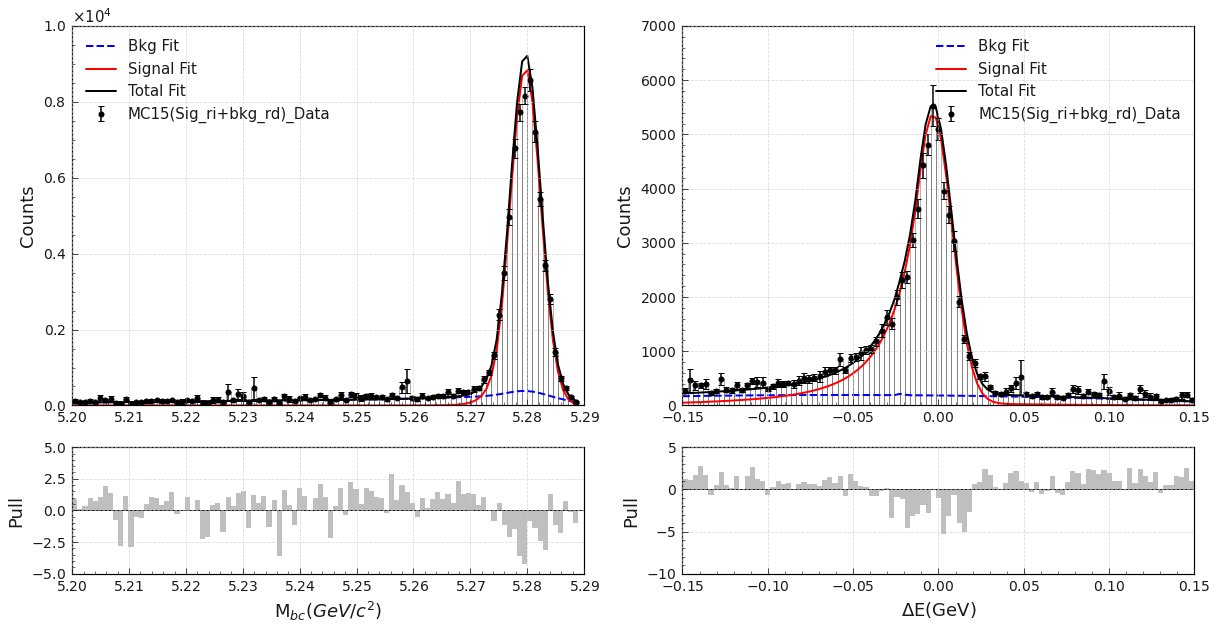

In [11]:


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_ele_signal,mc_ele_scf, mc_ele_bkg,mc_ele_signal_weight,mc_ele_scf_weight,
              mc_ele_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('B0pip_q2reg0_decay_ee.pdf')
plt.show()
   
